In [1]:
%matplotlib inline

import intake
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
from scipy import stats
import warnings

from regress_utils import scatter_tas_SIE_linreg

/srv/conda/envs/notebook/lib/python3.7/site-packages/intake/source/discovery.py:136: FutureWarning: The drivers ['geojson', 'postgis', 'shapefile', 'spatialite'] do not specify entry_points and were only discovered via a package scan. This may break in a future release of intake. The packages should be updated.
  FutureWarning)


#### Load dataset

In [2]:
# Load dataset
collection_fname = 'dset_dict_historical.npy'
#collection_fname = 'dset_dict_piControl.npy'

dset_dict = np.load(collection_fname, allow_pickle='TRUE').item()
first_dset = list(dset_dict.keys())[0]
models_intersect = dset_dict[first_dset].keys()

#### Regression of sea ice extent on arctic temperature for each model for multiple ensemble members

In [3]:
# Set maximum number of ensemble members to look at for each model
#N.B. doing this for anomalies give you the same answer as not anomalies. Which makes sense when you think about it.
max_ems = 5

warnings.filterwarnings('ignore')

slopes_all, r_all = {}, {}
for m in models_intersect:
    # get ensemble members
    ems = dset_dict['siconc'][m]['member_id'].values
    if len(ems)>max_ems:
        ems = ems[0:max_ems]
    print(m, len(ems))
    
    # Perform regression
    slopes_all[m], r_all[m] = {}, {}
    for i, em in enumerate(ems):
        print(em)
        slopes_all[m][i], r_all[m][i] = scatter_tas_SIE_linreg(
                                                        dset_dict['tas'][m]['tas_arc_mean'].sel(member_id=em),
                                                        dset_dict['siconc'][m]['sie_tot_arc'].sel(member_id=em),
                                                        [2,8], False, m)

warnings.filterwarnings('default')

NorCPM1 3
r26i1p1f1
r17i1p1f1
r23i1p1f1
MIROC-ES2L 3
r1i1p1f2
r2i1p1f2
r3i1p1f2
NorESM2-LM 1
r2i1p1f1
MPI-ESM1-2-HR 3
r4i1p1f1
r2i1p1f1
r9i1p1f1
CanESM5-CanOE 3
r1i1p2f1
r3i1p2f1
r2i1p2f1
CESM2 5
r4i1p1f1
r5i1p1f1
r10i1p1f1
r7i1p1f1
r1i1p1f1
MRI-ESM2-0 5
r4i1p1f1
r5i1p1f1
r1i1p1f1
r2i1p1f1
r3i1p1f1
CanESM5 5
r5i1p1f1
r24i1p1f1
r3i1p2f1
r17i1p1f1
r1i1p1f1
CESM2-WACCM-FV2 1
r1i1p1f1
CESM2-FV2 1
r1i1p1f1
MIROC6 5
r4i1p1f1
r5i1p1f1
r10i1p1f1
r7i1p1f1
r1i1p1f1
SAM0-UNICON 1
r1i1p1f1
ACCESS-ESM1-5 3
r2i1p1f1
r3i1p1f1
r1i1p1f1
ACCESS-CM2 2
r2i1p1f1
r1i1p1f1


In [4]:
# Calculate ensemble mean and r values for each model
slopes_mean, r_mean = {}, {}

print('Model, slopes (mar, sept), r (mar, sept)')
print()
for m in models_intersect:
    slopes_mean_temp, r_mean_temp = [], []
    for em in slopes_all[m].keys():
        slopes_mean_temp.append(slopes_all[m][em])
        r_mean_temp.append(r_all[m][em])        
        
    slopes_mean[m] = np.mean(slopes_mean_temp,0)
    r_mean[m] = np.mean(r_mean_temp,0)
    
    print(m, slopes_mean[m], r_mean[m])

Model, slopes (mar, sept), r (mar, sept)

NorCPM1 [-0.05525938 -0.21451181] [-0.24509121 -0.68413531]
MIROC-ES2L [-0.09192133 -0.65859899] [-0.36098676 -0.82239082]
NorESM2-LM [-0.04339587 -0.61937929] [-0.25928011 -0.63112629]
MPI-ESM1-2-HR [-0.07931427 -0.68827554] [-0.30087892 -0.38740697]
CanESM5-CanOE [-0.18316136 -0.46589789] [-0.48428173 -0.76030876]
CESM2 [-0.08902344 -1.14288634] [-0.57013415 -0.82772033]
MRI-ESM2-0 [-0.09075756 -0.87921444] [-0.40793578 -0.78230067]
CanESM5 [-0.20185505 -0.51481767] [-0.52500713 -0.79849741]
CESM2-WACCM-FV2 [-0.04315566 -0.71979453] [-0.27963064 -0.69283106]
CESM2-FV2 [-0.04049284 -0.92662303] [-0.23447136 -0.73824288]
MIROC6 [-0.08442812 -0.63095041] [-0.42629104 -0.83244392]
SAM0-UNICON [-0.09876842 -0.39225192] [-0.32149741 -0.73354963]
ACCESS-ESM1-5 [-0.19504076 -0.53949328] [-0.49922439 -0.68638816]
ACCESS-CM2 [-0.18163913 -0.65066614] [-0.39708171 -0.77835184]


#### Save

In [5]:
# Save dictionaries for future use
results_fname = 'results_' + collection_fname[10:]
save_flag = True
if save_flag:
    if dset_dict:
        np.save(results_fname, slopes_mean, r_mean)

#### Plots

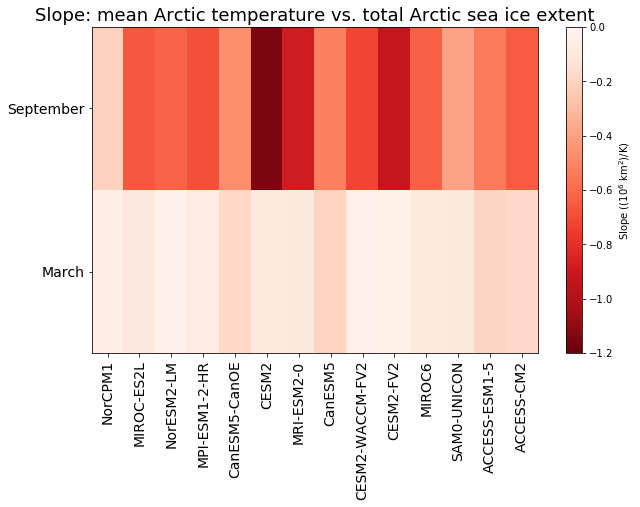

In [6]:
# Plot slopes for all models
slopes_plot = np.zeros((2,len(slopes_mean.keys())))

for im, m in enumerate(slopes_mean.keys()):
    slopes_plot[0,im] = slopes_mean[m][0]
    slopes_plot[1,im] = slopes_mean[m][1]
    
fig = plt.figure(figsize=(10,6))
plt.pcolormesh(slopes_plot, cmap='Reds_r')
plt.clim(0, -1.2)
plt.xticks(np.arange(0, len(models_intersect), 1) + 0.5,list(slopes_all.keys()),fontsize=14, rotation='vertical')
plt.yticks([0.5,1.5],['March','September'],fontsize=14)
plt.title('Slope: mean Arctic temperature vs. total Arctic sea ice extent', fontsize=18)
plt.colorbar(label='Slope ((10$^{6}$ km$^{2}$)/K)')

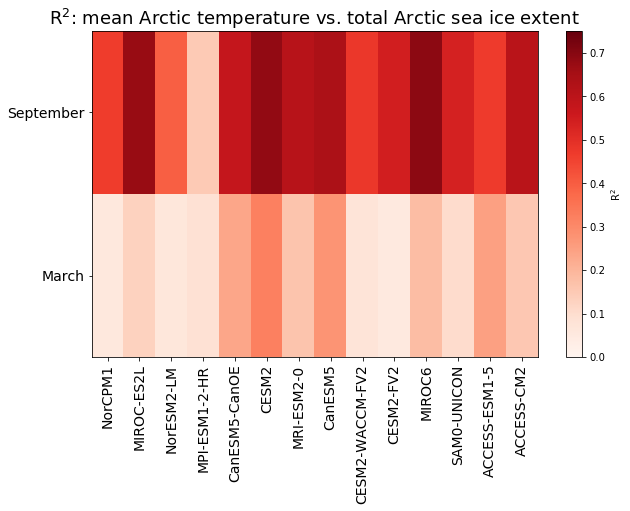

In [7]:
# Plot R squared for all models
r_plot = np.zeros((2,len(r_mean.keys())))

for im, m in enumerate(r_mean.keys()):
    r_plot[0,im] = r_mean[m][0]*r_mean[m][0]
    r_plot[1,im] = r_mean[m][1]*r_mean[m][1]
    
fig = plt.figure(figsize=(10,6))
plt.pcolormesh(r_plot, cmap='Reds')
plt.clim(0, 0.75)
plt.xticks(np.arange(0, len(models_intersect), 1) + 0.5,list(slopes_all.keys()),fontsize=14, rotation='vertical')
plt.yticks([0.5,1.5],['March','September'],fontsize=14)
plt.title('R$^{2}$: mean Arctic temperature vs. total Arctic sea ice extent', fontsize=18)
plt.colorbar(label='R$^{2}$')